In [1]:
import pandas as pd
import numpy as np
import os
import gc
import datetime as dt
import warnings

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 20
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [12, 8]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 5))  
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.neural_network import MLPRegressor,MLPClassifier
from xgboost import XGBClassifier, XGBRegressor

from sklearn.linear_model import LassoCV,Lasso
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing

from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from alibi.explainers import ALE, plot_ale, AnchorTabular

import warnings 
warnings.filterwarnings('ignore')

import alibi
import shap
from sklearn_gbmi import *

In [10]:
def metrics(model):  
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train,y_train, cv=5)
    print('Train')
    print('CV score: %f'%np.mean(scores))
    print('MSE: %f '%mse(y_train, train_pred))
    print('-----------------------------------------')
    
    scores = cross_val_score(model, X_test,y_test, cv=5)
    print('Test')
    print('CV score: %f'%np.mean(scores))
    print('MSE: %f'%mse(y_test, test_pred))

def transform_plot(model):
    train_pred = model.predict(X_train)
    
    fig,axes = plt.subplots(2,2,sharey=True,figsize=(9,9))
    axes[0,0].scatter(X_train['x1'],y_train,label='true x1')
    axes[0,0].scatter(X_train['x1'],train['x1_transform']*5,label='function')
    axes[0,1].scatter(X_train['x1'],train_pred,label='pred x1')
    axes[0,1].scatter(X_train['x1'],train['x1_transform']*5,label='function')
    
    axes[1,0].scatter(train['x1_transform'],y_train,label='true x1_transform')
    axes[1,1].scatter(train['x1_transform'],train_pred,label='pred x1_transform')

    axes[0,0].legend(loc='upper right')
    axes[0,1].legend(loc='upper right')
    axes[1,0].legend(loc='upper right')
    axes[1,1].legend(loc='upper right')
    plt.show()

    fig,axes = plt.subplots(2,2,sharey=True,figsize=(9,9))
    axes[0,0].scatter(X_train['x2'],y_train,label='true x2')
    axes[0,0].scatter(X_train['x2'],train['x2_transform'],label='function')
    axes[0,1].scatter(X_train['x2'],train_pred,label='pred x2')
    axes[0,1].scatter(X_train['x2'],train['x2_transform'],label='function')
    
    axes[1,0].scatter(train['x2_transform'],y_train,label='true x2_transform')
    axes[1,1].scatter(train['x2_transform'],train_pred,label='pred x2_transform')

    axes[0,0].legend(loc='upper right')
    axes[0,1].legend(loc='upper right')
    axes[1,0].legend(loc='upper right')
    axes[1,1].legend(loc='upper right')
    plt.show()

    fig,axes = plt.subplots(2,2,sharey=True,figsize=(9,9))
    axes[0,0].scatter(X_train['x3'],y_train,label='true x3')
    axes[0,0].scatter(X_train['x3'],-train['x3_transform']*3,label='function')
    axes[0,1].scatter(X_train['x3'],train_pred,label='pred x3')
    axes[0,1].scatter(X_train['x3'],-train['x3_transform']*3,label='function')
    
    axes[1,0].scatter(-train['x3_transform']*3,y_train,label='true x3_transform')
    axes[1,1].scatter(-train['x3_transform']*3,train_pred,label='pred x3_transform')

    axes[0,0].legend(loc='upper right')
    axes[0,1].legend(loc='upper right')
    axes[1,0].legend(loc='upper right')
    axes[1,1].legend(loc='upper right')
    plt.show()

## Simulation

In [2]:
x1 = np.random.normal(0,size=50000)
x2 = np.random.normal(0,size=50000)
x3 = np.random.normal(0,size=50000)
x4 = np.random.standard_t(8,size=50000)

x5 = np.linspace(-3,3,num=50000)
np.random.shuffle(x5)

x6 = np.linspace(-3,3,num=50000)
np.random.shuffle(x6)


residual = np.random.standard_t(10,size=50000)
simulation = pd.DataFrame(data=np.array([x1,x2,x3,x4,x5,x6,residual]).T)
simulation.columns = ['x1','x2','x3','x4','x5','x6','residual']

def transform1(x):
    if x>1.2 or x<-0.5:
        return(x)
    else:
        return(0)

def transform2(x):
    if 3>x>1.2:
        return(x**2)
    elif x>-2.5:
        return(-x-1)
    else:
        return(0)
        
def transform45(x):
    if x.x4>1 and x.x5<-0.2:
        return(x.x4*x.x5)
    else:
        return(x.x5/2)       

simulation['x1_transform'] = simulation.x1.apply(transform1)
simulation['x2_transform'] = simulation.x2.apply(transform2)
simulation['x45_transform'] = simulation.apply(transform45,axis=1)
simulation['x3_transform'] = np.sin(np.pi/2*simulation.x3) 

simulation['y'] = simulation['x1_transform']*3 - simulation['x3_transform']*2 - simulation['x45_transform']*2 \
         + simulation['x2_transform']  + simulation['residual']

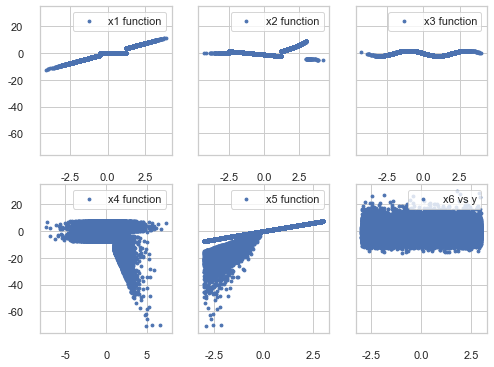

In [68]:
fig,axes = plt.subplots(2,3,sharey=True,figsize=(8,6))
axes[0,0].scatter(simulation['x1'],simulation['x1_transform']*3,s=8,label='x1 function')
axes[0,1].scatter(simulation['x2'],simulation['x2_transform'],s=8,label='x2 function')
axes[0,2].scatter(simulation['x3'],-simulation['x3_transform']*2,s=8,label='x3 function')
axes[1,0].scatter(simulation['x4'],simulation['x45_transform']*5,s=8,label='x4 function')
axes[1,1].scatter(simulation['x5'],simulation['x45_transform']*5,s=8,label='x5 function')
axes[1,2].scatter(simulation['x6'],simulation['y'],s=8,label='x6 vs y')

axes[0,0].legend(loc='upper right')
axes[0,1].legend(loc='upper right')
axes[0,2].legend(loc='upper right')
axes[1,0].legend(loc='upper right')
axes[1,1].legend(loc='upper right')
axes[1,2].legend(loc='upper right')
plt.show()

In [4]:
X = simulation[['x1','x2','x3','x4','x5','x6']]
Y = simulation['y']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=52)
train = pd.merge(X_train,simulation)
test = pd.merge(X_test,simulation)

In [4]:
linear = LinearRegression().fit(X_train,y_train)
lasso = LassoCV(cv=5,fit_intercept=True,alphas=np.linspace(0.00001,0.001,100)).fit(X_train,y_train) 
DT = DecisionTreeRegressor(max_depth=10,random_state=0).fit(X_train,y_train)
knn = KNeighborsRegressor(n_neighbors=10).fit(preprocessing.scale(X_train),y_train)
rf = RandomForestRegressor(max_depth=10).fit(X_train,y_train)
ada = AdaBoostRegressor(random_state=0, n_estimators=100).fit(X_train,y_train)
xg = XGBRegressor(max_depth=10).fit(X_train,y_train)
gb = GradientBoostingRegressor(random_state=0, n_estimators=100).fit(X_train,y_train)
mlp = MLPRegressor(solver='lbfgs', alpha=0.01,hidden_layer_sizes=(15,3), random_state=1).fit(X_train,y_train)

[00:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [72]:
print('Linear:')
metrics(linear)
print('\nDT:')
metrics(DT)
print('\nknn:')
metrics(knn)
print('\nAdaboost:')
metrics(ada)
print('\nXGB:')
metrics(xg)
print('\nGradient Boost:')
metrics(gb)
print('\nMultilayer Perceptron:')
metrics(mlp)
print('\nRandom Forest:')
metrics(rf)

Linear:
Train
CV score: 0.624063
MSE: 6.925729 
-----------------------------------------
Test
CV score: 0.622420
MSE: 7.148711

DT:
Train
CV score: 0.855865
MSE: 1.881710 
-----------------------------------------
Test
CV score: 0.842382
MSE: 2.621795

knn:
Train
CV score: 0.824654
MSE: 3.090890 
-----------------------------------------
Test
CV score: 0.797334
MSE: 3.720404

Adaboost:
Train
CV score: 0.794063
MSE: 3.550469 
-----------------------------------------
Test
CV score: 0.800514
MSE: 3.705053

XGB:
[23:53:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:53:25] WARNING: 

### PDP and ALE

array([[<AxesSubplot:xlabel='x1', ylabel='ALE'>,
        <AxesSubplot:xlabel='x2', ylabel='ALE'>,
        <AxesSubplot:xlabel='x3', ylabel='ALE'>],
       [<AxesSubplot:xlabel='x4', ylabel='ALE'>,
        <AxesSubplot:xlabel='x5', ylabel='ALE'>,
        <AxesSubplot:xlabel='x6', ylabel='ALE'>]], dtype=object)

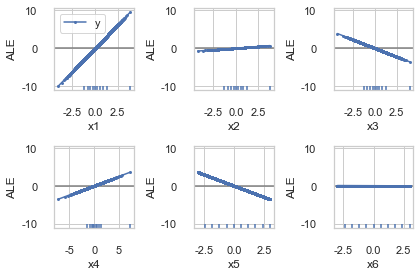

In [60]:
ale_linear = ALE(linear.predict,feature_names=list(X_train.columns), target_names = ['y'])
exp_linear = ale_linear.explain(X_train.values)
plot_ale(exp_linear, fig_kw={'figwidth':6, 'figheight': 4})

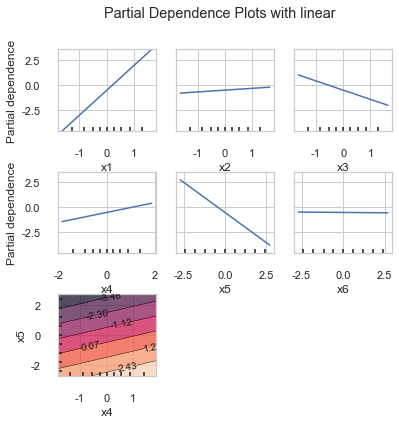

In [61]:
plot_partial_dependence(linear, X_train, features) 
fig = plt.gcf()
fig.set_size_inches(6, 6) 

fig.suptitle('Partial Dependence Plots with linear')
fig.subplots_adjust(hspace=0.5)

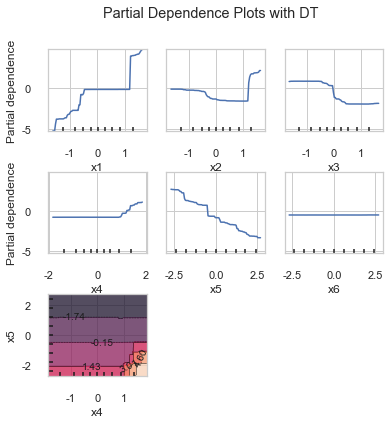

In [65]:
plot_partial_dependence(DT, X_train, features) 
fig = plt.gcf()
fig.set_size_inches(6, 6) 

fig.suptitle('Partial Dependence Plots with DT')
fig.subplots_adjust(hspace=0.5)

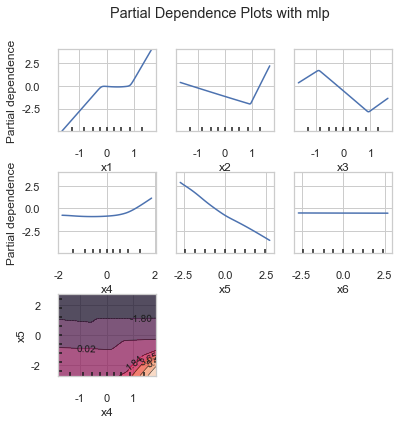

In [66]:
plot_partial_dependence(mlp, X_train, features) 
fig = plt.gcf()
fig.set_size_inches(6, 6) 

fig.suptitle('Partial Dependence Plots with mlp')
fig.subplots_adjust(hspace=0.5)

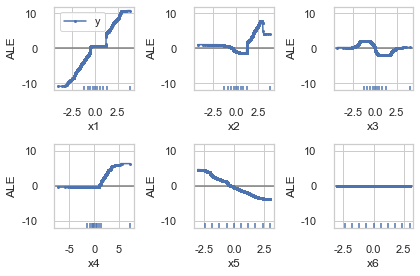

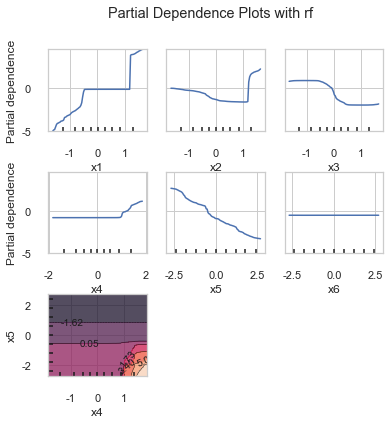

In [64]:
ale_rf = ALE(rf.predict,feature_names=list(X_train.columns), target_names = ['y'])
exp_rf = ale_rf.explain(X_train.values)
plot_ale(exp_rf, fig_kw={'figwidth':6, 'figheight': 4})

plot_partial_dependence(rf, X_train, features) 
fig = plt.gcf()
fig.set_size_inches(6, 6) 

fig.suptitle('Partial Dependence Plots with rf')
fig.subplots_adjust(hspace=0.5)

## SHAP
SHAP is a local surrogate model, fast on tree models but slow on other kernals. SHAP can show interactions

In [5]:
rf_shap = shap.TreeExplainer(rf)
DT_shap = shap.TreeExplainer(DT)
xg_shap = shap.TreeExplainer(xg)
gb_shap = shap.TreeExplainer(gb)
#Not applicable for Adaboosting, Kernal Shap can very slow

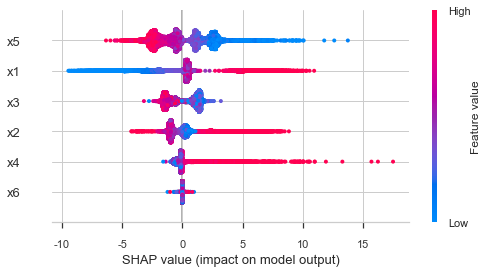

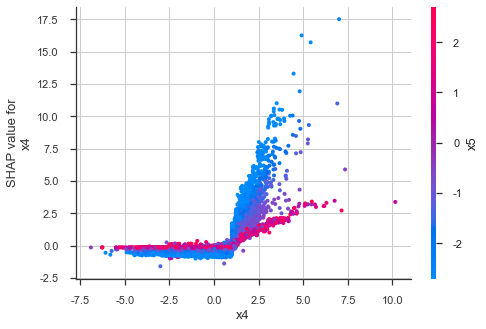

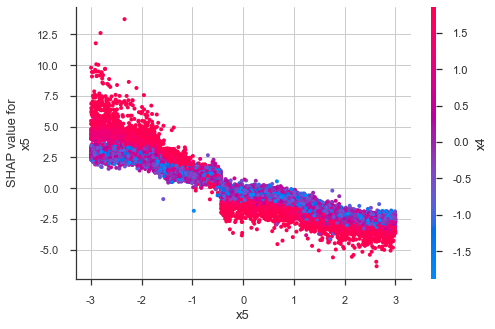

In [6]:
# Decision Tree
DT_shap_values = DT_shap.shap_values(X_train)
DT_shap_interaction = DT_shap.shap_interaction_values(X_train)
shap.summary_plot(DT_shap_values, X_train)
shap.dependence_plot(3, DT_shap_values, X_train)
shap.dependence_plot(4, DT_shap_values, X_train)

In [20]:
shap.initjs()
def shap_plot(j):
    explainerModel = shap.TreeExplainer(DT)
    shap_values_Model = explainerModel.shap_values(X_train)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train.iloc[[j]])
    return(p)
shap_plot(0)

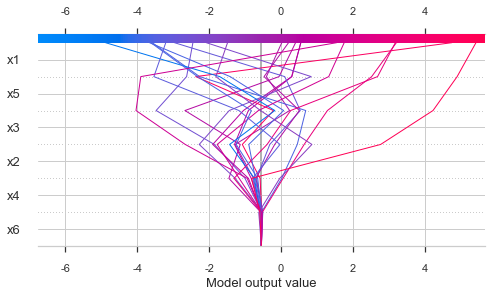

In [29]:
DT_1 = DecisionTreeRegressor(max_depth=10,random_state=0).fit(X_train[:2000],y_train[:2000])
DT_shap1 = shap.TreeExplainer(DT_1)
DT_shap_values1 = DT_shap1.shap_values(X_train[:20])
expected_value = DT_shap1.expected_value
shap.decision_plot(expected_value, DT_shap_values1, ['x1','x2','x3','x4','x5','x6'])

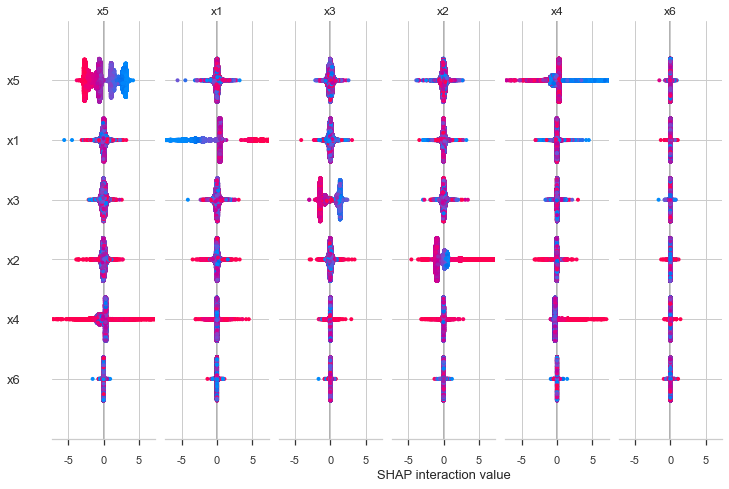

In [36]:
shap.summary_plot(DT_shap_interaction, X_train)

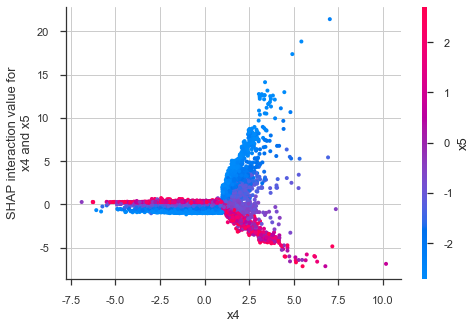

In [37]:
shap.dependence_plot(
    ("x4", "x5"),
    DT_shap_interaction, X_train,
    display_features=X_train
)

In [6]:
DT_1 = DecisionTreeRegressor(max_depth=10,random_state=0).fit(X_train[:2000],y_train[:2000])
DT_shap1 = shap.TreeExplainer(DT_1)
DT_shap_values1 = DT_shap1.shap_values(X_train[:2000])
shap.force_plot(DT_shap1.expected_value, DT_shap_values1, X_train)

In [ ]:
# Random Forest
rf_shap_values = rf_shap.shap_values(X_train)
rf_shap_interaction = rf_shap.shap_interaction_values(X_train)
shap.summary_plot(rf_shap_values, X_train)
shap.dependence_plot(3, rf_shap_values, X_train)
shap.dependence_plot(4, rf_shap_values, X_train)

In [ ]:
# Gradient Boost
gb_shap_values = rf_shap.shap_values(X_train)
rf_shap_interaction = rf_shap.shap_interaction_values(X_train)
shap.summary_plot(rf_shap_values, X_train)
shap.dependence_plot(3, rf_shap_values, X_train)
shap.dependence_plot(4, rf_shap_values, X_train)

In [ ]:
# XGBoosting
xg_shap_values = xg_shap.shap_values(X_train)
xg_shap_interaction = xg_shap.shap_interaction_values(X_train)
shap.summary_plot(xg_shap_values, X_train)
shap.dependence_plot(3, xg_shap_values, X_train)
shap.dependence_plot(4, xg_shap_values, X_train)

## H-stats


In [8]:
d = h_all_pairs(gb, X_train)
l=sorted(d.items(), key=lambda x: x[1])
l

[(('x1', 'x6'), 0.0),
 (('x2', 'x6'), 0.0),
 (('x3', 'x6'), 0.0),
 (('x4', 'x6'), 0.0),
 (('x5', 'x6'), 0.0),
 (('x1', 'x4'), 0.018247898455762177),
 (('x2', 'x3'), 0.02000960172013663),
 (('x1', 'x3'), 0.02072307508076464),
 (('x1', 'x2'), 0.022537958682174956),
 (('x2', 'x4'), 0.022676314732465872),
 (('x2', 'x5'), 0.023382811068696392),
 (('x3', 'x4'), 0.023706683694705195),
 (('x3', 'x5'), 0.025922121088696737),
 (('x1', 'x5'), 0.030957746983897656),
 (('x4', 'x5'), 0.3543501715646169)]